In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import re
import glob
import suftware as su
from scipy.stats import norm
from scipy.stats import poisson

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../../../'
sys.path.insert(0,path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

e = np.exp(1)
pi = np.pi
def pseudo_log(x,base=e):
    return np.log(x+.5)/np.log(base)

['../../../../mavenn']


In [2]:
# Get in-file
in_file = f'results.brca2_9nt_lib1_rep1.txt'
        
# Create dict to record statistics
stats_dict = {}
        
# Load file
in_df = pd.read_csv(in_file, delimiter='\t', index_col=0)
print(f'Processing {in_file}')

# Remove extraneous columns
del in_df['mis_ct']
del in_df['lib_ct']

in_df.head()

Processing results.brca2_9nt_lib1_rep1.txt


,tot_ct,ex_ct,ss,bc
0,377,27,ACAGCGGGA,TTAGCTATCGGCTGACGTCT
1,332,5,AGCGTGTAT,CCACCCAACGCGCCGTCAGT
2,320,3286,CAGGTGAGA,TTGAGGTACACTGAACAGTC
3,312,2248,CAGGTTAGA,ACCGATCTGCCACGGCGACC
4,291,8,CAAGCCTTA,AGGGACCATCCAGTTCGCCT


In [3]:
# Marginalize by splice site
data_df = in_df.groupby('ss').sum()
data_df.reset_index(inplace=True)

<AxesSubplot:xlabel='tot_ct', ylabel='Count'>

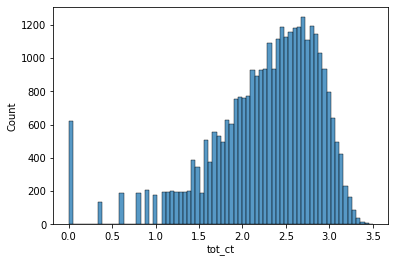

In [4]:
sns.histplot(np.log10(np.exp(1))*np.arcsinh(data_df['tot_ct']))

In [5]:
# Remove ss with minimum tot_ct
ix = data_df['tot_ct'] >= 10
data_df = data_df[ix]

In [6]:
# Sort by tot_ct
data_df.sort_values(by='tot_ct', inplace=True, ascending=False)
data_df.reset_index(inplace=True, drop=True)

# Make sequences RNA
data_df['ss'] = [ss.replace('T','U') for ss in data_df['ss']]

# Rename columns
data_df.rename(columns={'ss':'x'}, inplace=True)

# Compute y
i_n = data_df['tot_ct']
o_n = data_df['ex_ct']
y_n = np.log2((o_n+1)/(i_n+1))
data_df['y'] = y_n

# Assign to trianing and test sets
N = len(data_df)
training_frac=.8
np.random.seed(0)
data_df['training_set'] = (np.random.rand(N) < training_frac)

# Order columns
data_df = data_df[['training_set', 'tot_ct', 'ex_ct', 'y', 'x']]

# Preview dataframe
print(f'N: {N:,}')
data_df.head(20)

N: 30,490


,training_set,tot_ct,ex_ct,y,x
0,True,1588,66,-4.567814,ACGGUCCAU
1,True,1533,118,-3.688265,AUUGCCAGG
2,True,1459,399,-1.867896,ACAGCGGUA
3,True,1414,246,-2.518219,AACGCCAGG
4,True,1412,60,-4.533808,ACGGCUUGG
5,True,1412,11147,2.979952,AAGGUGGGA
6,True,1396,57,-4.590135,ACGGCUUAU
7,False,1384,14692,3.407171,CAGGUGGGA
8,False,1378,12990,3.235818,AAGGUUGGU
9,True,1336,43,-4.925352,UCAGUGGGA


In [7]:
# Show size of compressed dataset file
file_name = 'mpsa_data.csv.gz'
data_df.to_csv(file_name, compression='gzip', index=False)
print('df (zipped):')
!du -mh $file_name
!mv $file_name ../.

df (zipped):
268K	mpsa_data.csv.gz


In [8]:
# Test loading
loaded_df = mavenn.load_example_dataset('mpsa')
loaded_df.head()

,training_set,tot_ct,ex_ct,y,x
0,True,1588,66,-4.567814,ACGGUCCAU
1,True,1533,118,-3.688265,AUUGCCAGG
2,True,1459,399,-1.867896,ACAGCGGUA
3,True,1414,246,-2.518219,AACGCCAGG
4,True,1412,60,-4.533808,ACGGCUUGG
